## data cleansing, EDA, model creation
 - POS_CASH_balance, installments_payments, credit_card_balance 

In [23]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import clear_output
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score
from random import randint




### load dataset under colab

In [2]:
import os, sys

In [3]:
default_dir = "../input/home-credit-default-risk/"

In [4]:
# This is inserted by us for the purpose of connecting to google drive to load the data. It was not part of the original code
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### column data type convert to reduce memory allocated size

In [5]:
def get_balance_data():
    pos_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int32, 'SK_DPD':np.int32,
        'SK_DPD_DEF':np.int32, 'CNT_INSTALMENT':np.float32,'CNT_INSTALMENT_FUTURE':np.float32
    }
    
    install_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'NUM_INSTALMENT_NUMBER':np.int32, 'NUM_INSTALMENT_VERSION':np.float32,
        'DAYS_INSTALMENT':np.float32, 'DAYS_ENTRY_PAYMENT':np.float32, 'AMT_INSTALMENT':np.float32, 'AMT_PAYMENT':np.float32
    }
    
    card_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int16,
        'AMT_CREDIT_LIMIT_ACTUAL':np.int32, 'CNT_DRAWINGS_CURRENT':np.int32, 'SK_DPD':np.int32,'SK_DPD_DEF':np.int32,
        'AMT_BALANCE':np.float32, 'AMT_DRAWINGS_ATM_CURRENT':np.float32, 'AMT_DRAWINGS_CURRENT':np.float32,
        'AMT_DRAWINGS_OTHER_CURRENT':np.float32, 'AMT_DRAWINGS_POS_CURRENT':np.float32, 'AMT_INST_MIN_REGULARITY':np.float32,
        'AMT_PAYMENT_CURRENT':np.float32, 'AMT_PAYMENT_TOTAL_CURRENT':np.float32, 'AMT_RECEIVABLE_PRINCIPAL':np.float32,
        'AMT_RECIVABLE':np.float32, 'AMT_TOTAL_RECEIVABLE':np.float32, 'CNT_DRAWINGS_ATM_CURRENT':np.float32,
        'CNT_DRAWINGS_OTHER_CURRENT':np.float32, 'CNT_DRAWINGS_POS_CURRENT':np.float32, 'CNT_INSTALMENT_MATURE_CUM':np.float32
    }
          
    #Read data from Google Drive
    pos_bal = pd.read_csv('/content/drive/MyDrive/POS_CASH_balance.csv', dtype=pos_dtype)
    install = pd.read_csv('/content/drive/MyDrive/installments_payments.csv', dtype=install_dtype)
    card_bal = pd.read_csv('/content/drive/MyDrive/credit_card_balance.csv', dtype=card_dtype)
    
    #Read data from default directory - This is the original code. It has been commented out and replaced by code to read the data files from Google Drive
    #pos_bal = pd.read_csv(os.path.join(default_dir,'POS_CASH_balance.csv'), dtype=pos_dtype)
    #install = pd.read_csv(os.path.join(default_dir,'installments_payments.csv'), dtype=install_dtype)
    #card_bal = pd.read_csv(os.path.join(default_dir, 'credit_card_balance.csv'), dtype=card_dtype)
    
    return pos_bal, install, card_bal

pos_bal, install, card_bal = get_balance_data()

In [6]:
pos_bal.shape, install.shape, card_bal.shape

((10001358, 8), (13605401, 8), (3840312, 23))

### load package

In [7]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

### EDA , Feature Engineering

In [8]:
def get_apps_processed(apps):
    """
    feature engineering for apps
    """

    # 1.EXT_SOURCE_X FEATURE 
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

def get_prev_processed(prev):
  """
  feature engineering 
  for previouse application credit history
  """
  prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
  prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
  prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
  # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
  prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
  
  # Data Cleansing
  prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
  prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
  prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
  prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

  # substraction between DAYS_LAST_DUE_1ST_VERSION and DAYS_LAST_DUE
  prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
  
  # 1.Calculate the interest rate
  all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
  prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
      
  return prev
    
    
def get_prev_amt_agg(prev):
  """
  feature engineering for the previous credit appliction
  """
  # 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행. 
  agg_dict = {
        # 기존 컬럼 aggregation. 
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      # 가공 컬럼 aggregation
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
  }

  prev_group = prev.groupby('SK_ID_CURR')
  prev_amt_agg = prev_group.agg(agg_dict)

  # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
  prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
  
  return prev_amt_agg

def get_prev_refused_appr_agg(prev):
  """
  PREV_APPROVED_COUNT : Credit application approved count
  PREV_REFUSED_COUNT :  Credit application refused count
  """
  prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
  # unstack() 
  prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

  # rename column 
  prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
  
  # NaN값은 모두 0으로 변경. 
  prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
  
  return prev_refused_appr_agg

#### DAYS_DECISION이 -365일 이전 데이터 세트 추가 가공. 

def get_prev_days365_agg(prev):
  """
  DAYS_DESCISION means How many days have been take since the previous credit application made.
  Somewhat this feature is important.
  """
  cond_days365 = prev['DAYS_DECISION'] > -365
  prev_days365_group = prev[cond_days365].groupby('SK_ID_CURR')
  agg_dict = {
        # 기존 컬럼 aggregation. 
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      # 가공 컬럼 aggregation
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
  }
  
  prev_days365_agg = prev_days365_group.agg(agg_dict)

  # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
  prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]
  
  return prev_days365_agg
    
def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    prev_days365_agg = get_prev_days365_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg = prev_agg.merge(prev_days365_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

# bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 컬럼 가공.
def get_bureau_processed(bureau):
    # 예정 채무 시작 및 완료일과 실제 채무 완료일간의 차이 및 날짜 비율 가공.  
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    # 채무 금액 대비/대출 금액 비율 및 차이 가공
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
    
    # 연체 여부 및 120일 이상 연체 여부 가공
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau


def get_bureau_day_amt_agg(bureau):
  '''
  bureau 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성 
  '''      
  bureau_agg_dict = {
  'SK_ID_BUREAU':['count'],
  'DAYS_CREDIT':['min', 'max', 'mean'],
  'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
  'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
  'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
  'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
  'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
  'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
  'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
  'AMT_ANNUITY': ['max', 'mean', 'sum'],
  # 추가 가공 컬럼
  'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
  'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
  'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
  'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
  'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
  'BUREAU_IS_DPD':['mean', 'sum'],
  'BUREAU_IS_DPD_OVER120':['mean', 'sum']
  }

  bureau_grp = bureau.groupby('SK_ID_CURR')
  bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
  bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
  # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
  bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
  #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
  return bureau_day_amt_agg


def get_bureau_active_agg(bureau):
  '''
  Bureau의 CREDIT_ACTIVE='Active' 인 데이터만 filtering 후 
  주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성
  '''
  # CREDIT_ACTIVE='Active' 인 데이터만 filtering
  cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
  bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
  bureau_agg_dict = {
      'SK_ID_BUREAU':['count'],
      'DAYS_CREDIT':['min', 'max', 'mean'],
      'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
      'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['max', 'mean', 'sum'],
      # 추가 가공 컬럼
      'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
      'BUREAU_IS_DPD':['mean', 'sum'],
      'BUREAU_IS_DPD_OVER120':['mean', 'sum']
      }

  bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
  bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
  # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
  bureau_active_agg = bureau_active_agg.reset_index()
  #print('bureau_active_agg shape:', bureau_active_agg.shape)
  return bureau_active_agg

# BUREAU의 DAYS_CREDIT 가 -750보다 최근 데이터 별도 가공. 
def get_bureau_days750_agg(bureau):
    cond_days750 = bureau['DAYS_CREDIT'] > -750
    bureau_days750_group = bureau[cond_days750].groupby('SK_ID_CURR')
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        # 추가 가공 컬럼
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_days750_agg = bureau_days750_group.agg(bureau_agg_dict)
    bureau_days750_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_days750_agg.columns.ravel()]
    bureau_days750_agg = bureau_days750_agg.reset_index()
    
    return bureau_days750_agg


# bureau_bal을 SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
def get_bureau_bal_agg(bureau, bureau_bal):
    # SK_ID_CURR레벨로 Group by하기 위해 bureau에서 SK_ID_CURR 컬럼을 가져오는 조인 수행. 
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    
    # STATUS에 따라 월별 연체 여부 및 120일 이상 연체 여부 속성 가공. 
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_bal_agg = bureau_bal_agg.reset_index()
    #print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg
    
# 가공된 bureau관련 aggregation 컬럼들을 모두 결합   
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_days750_agg = get_bureau_days750_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    
    # bureau_day_amt_agg와 bureau_active_agg 조인.  
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    # STATUS가 ACTIVE IS_DPD RATIO관련 비율 재가공. 
    #bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    #bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    
    # bureau_agg와 bureau_bal_agg 조인. 
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_days750_agg, on='SK_ID_CURR', how='left') 
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

    #print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg

def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test
    
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=2000,
                learning_rate=0.02,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                )
   
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 200)
    
    return clf

#### aggregation for pos, install, credit card

In [9]:
def get_pos_bal_agg(pos_bal):
    # 연체 일자(SK_DPD)가 0 보다 큰 경우, 0~ 100 사이, 100보다 큰 경우 조사 
    cond_over_0 = pos_bal['SK_DPD'] > 0
    cond_100 = (pos_bal['SK_DPD'] < 100) & (pos_bal['SK_DPD'] > 0)
    cond_over_100 = (pos_bal['SK_DPD'] >= 100)

    # 연체여부,  연체일수 0~ 120 사이 여부, 연체 일수 120보다 큰 여부 
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 신규 컬럼으로 SK_ID_CURR 레벨로 신규 aggregation 컬럼 생성
    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        # 추가 컬럼. 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)
    # 컬럼명 변경 
    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]
    
    # MONTHS_BALANCE가 최근(20개월 이하)인 데이터 세트 별도 가공. 
    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m20_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        # 추가 컬럼. 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_m20_agg_dict)
    # 컬럼 변경 
    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')
    
    # SK_ID_CURR을 reset_index()를 이용하여 컬럼으로 변환
    pos_bal_agg = pos_bal_agg.reset_index()
    
    
    return pos_bal_agg

def get_install_agg(install):
    # 예정 납부 금액 대비 실제 납부 금액 관련 데이터 가공. 예정 납부 일자 대비 실제 납부 일자 비교를 DPD 일자 생성  
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1)
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

    # 연체여부,  연체일수 30~ 120 사이 여부, 연체 일수 100보다 큰 여부 데이터 가공. 
    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 신규 컬럼으로 SK_ID_CURR 레벨로 신규 aggregation 컬럼 생성. 
    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],
        #  추가 컬럼
        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]

    
    # 실제 납부 일자(DAYS_ENTRY_PAYMENT)가 비교적 최근(1년 이내) 데이터만 별도로 가공
    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],
        #  추가 컬럼
        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }
    
    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]
    
    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()
    
    return install_agg

def get_card_bal_agg(card_bal):
    # 월별 카드 허용한도에 따른 잔고와 인출 금액 비율 
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    # DPD에 따른 가공 컬럼 생성.
    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 가공 컬럼으로 SK_ID_CURR 레벨로 aggregation 신규 컬럼 생성. 
    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
         #'MONTHS_BALANCE':['min', 'max', 'mean'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],
        #  추가 컬럼
        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']    
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()
    
    # MONTHS_BALANCE가 비교적 최근 데이터( 3개월 이하)만 별도로 가공.  
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg

### datasets concatenation and Join

In [10]:
# apps와 prev_agg, bureau_agg, pos_bal_agg, install_agg, card_bal_agg를 개별 함수 호출하여 생성후 조인 결합
def get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal):
  """
  Description :
  1.Data preparation , aggregation 
  2.produce the finalized result
  """
  apps_all =  get_apps_processed(apps)
  prev_agg = get_prev_agg(prev)
  bureau_agg = get_bureau_agg(bureau, bureau_bal)
  pos_bal_agg = get_pos_bal_agg(pos_bal)
  install_agg = get_install_agg(install)
  card_bal_agg = get_card_bal_agg(card_bal)
  print('prev_agg shape:', prev_agg.shape, 'bureau_agg shape:', bureau_agg.shape )
  print('pos_bal_agg shape:', pos_bal_agg.shape, 'install_agg shape:', install_agg.shape, 'card_bal_agg shape:', card_bal_agg.shape)
  print('apps_all before merge shape:', apps_all.shape)
  
  # Join with apps_all
  apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
  apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
  apps_all = apps_all.merge(pos_bal_agg, on='SK_ID_CURR', how='left')
  apps_all = apps_all.merge(install_agg, on='SK_ID_CURR', how='left')
  apps_all = apps_all.merge(card_bal_agg, on='SK_ID_CURR', how='left')
    
  print('apps_all after merge with all shape:', apps_all.shape)
  
  return apps_all

### reload the original *datasets*

In [31]:
def get_dataset():
  """
  load datasets
  1.app_train - train dataset 
  2.app_test - test datasets
  3.apps - concatenated app_train, app_test
  4.pos_bal - POS_CACHE
  5.install - installments_payments
  6.card_bal - Credit Card
  """
  
  #Read files from Google Drive - We inserted this code to load the files from Google Drive
  app_train = pd.read_csv('/content/drive/MyDrive/application_train.csv')
  #app_test1 = pd.read_csv('/content/drive/MyDrive/application_test.csv')
  app_test = pd.read_csv('/content/drive/MyDrive/application_train_with_target_removed.csv')
  prev = pd.read_csv('/content/drive/MyDrive/previous_application.csv')
  bureau = pd.read_csv('/content/drive/MyDrive/bureau.csv')
  bureau_bal = pd.read_csv('/content/drive/MyDrive/bureau_balance.csv')
  submission = pd.read_csv('/content/drive/MyDrive/submission.csv')
  train_with_pred = pd.read_csv('/content/drive/MyDrive/application_train_with_prediction_added.csv')

  #Read files based on default directory - #This is the orignal code. We replaced it with the code above to load the data from Google Drive
  #app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
  #app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))
  #prev = pd.read_csv(os.path.join(default_dir,'previous_application.csv'))
  #bureau = pd.read_csv(os.path.join(default_dir,'bureau.csv'))
  #bureau_bal = pd.read_csv(os.path.join(default_dir,'bureau_balance.csv'))

  apps = pd.concat([app_train, app_test]) 
  pos_bal, install, card_bal = get_balance_data()
      
  return apps, prev, bureau, bureau_bal, pos_bal, install, card_bal

In [12]:
apps, prev, bureau, bureau_bal, pos_bal, install, card_bal = get_dataset()

### Data preparation, encodeing, datasets split, fit

In [13]:
# application, previous, bureau, bureau_bal 관련 데이터셋 가공 및 취합. 
apps_all = get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal)


# Category 컬럼을 모두 Label 인코딩 수행. 
#apps_all = get_apps_all_encoded(apps_all)

# 학습과 테스트 데이터로 분리. 
#apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

#학습수행. 
#clf = train_apps_all(apps_all_train)
#preds = clf.predict_proba(apps_all_train.drop(['SK_ID_CURR'], axis=1))[:, 1 ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:244: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:276: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:300: FutureWarning: Index.ravel returning nda

prev_agg shape: (338857, 80) bureau_agg shape: (305811, 149)
pos_bal_agg shape: (337252, 45) install_agg shape: (339587, 59) card_bal_agg shape: (103558, 70)
apps_all before merge shape: (615022, 135)
apps_all after merge with all shape: (615022, 534)


In [14]:
# Category 컬럼을 모두 Label 인코딩 수행. 
apps_all = get_apps_all_encoded(apps_all)

In [15]:
# 학습과 테스트 데이터로 분리. 
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

In [16]:
#학습수행. 
clf = train_apps_all(apps_all_train)

train shape: (215257, 532) valid shape: (92254, 532)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.798554	training's binary_logloss: 0.238269	valid_1's auc: 0.770721	valid_1's binary_logloss: 0.244936
[200]	training's auc: 0.822064	training's binary_logloss: 0.226495	valid_1's auc: 0.782232	valid_1's binary_logloss: 0.239059
[300]	training's auc: 0.839071	training's binary_logloss: 0.218782	valid_1's auc: 0.788005	valid_1's binary_logloss: 0.236721
[400]	training's auc: 0.852875	training's binary_logloss: 0.21261	valid_1's auc: 0.790608	valid_1's binary_logloss: 0.235657
[500]	training's auc: 0.865273	training's binary_logloss: 0.207139	valid_1's auc: 0.792155	valid_1's binary_logloss: 0.235063
[600]	training's auc: 0.87645	training's binary_logloss: 0.202137	valid_1's auc: 0.792911	valid_1's binary_logloss: 0.23473
[700]	training's auc: 0.886224	training's binary_logloss: 0.19758	valid_1's auc: 0.793552	valid_1's binary_logloss: 0.23447
[800]	t

In [17]:
# application, previous, bureau, bureau_bal 관련 데이터셋 가공 및 취합. 
apps_all = get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal)


# Category 컬럼을 모두 Label 인코딩 수행. 
apps_all = get_apps_all_encoded(apps_all)

# 학습과 테스트 데이터로 분리. 
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

#학습수행. 
clf = train_apps_all(apps_all_train)
#preds = clf.predict_proba(apps_all_train.drop(['SK_ID_CURR'], axis=1))[:, 1 ]
#preds = clf.predict_proba(apps_all_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:140: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:244: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:276: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:300: FutureWarning: Index.ravel returning nda

prev_agg shape: (338857, 80) bureau_agg shape: (305811, 149)
pos_bal_agg shape: (337252, 45) install_agg shape: (339587, 59) card_bal_agg shape: (103558, 70)
apps_all before merge shape: (615022, 135)
apps_all after merge with all shape: (615022, 534)
train shape: (215257, 532) valid shape: (92254, 532)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.798554	training's binary_logloss: 0.238269	valid_1's auc: 0.770721	valid_1's binary_logloss: 0.244936
[200]	training's auc: 0.822064	training's binary_logloss: 0.226495	valid_1's auc: 0.782232	valid_1's binary_logloss: 0.239059
[300]	training's auc: 0.839071	training's binary_logloss: 0.218782	valid_1's auc: 0.788005	valid_1's binary_logloss: 0.236721
[400]	training's auc: 0.852875	training's binary_logloss: 0.21261	valid_1's auc: 0.790608	valid_1's binary_logloss: 0.235657
[500]	training's auc: 0.865273	training's binary_logloss: 0.207139	valid_1's auc: 0.792155	valid_1's binary_logloss: 0.235063
[60

### CSV for Predicted result

In [18]:
#output_dir = "../output/kaggle/working/" #This is original code. We have replaced it with code to send the output files to Google Drive
output_dir = "/content/drive/MyDrive/"
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds
#apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(output_dir,'pos_install_credit_02.csv'), index=False) #This line is from the orifinal code. This is where the CSV file was created
apps_all_test[['SK_ID_CURR', 'TARGET']]


,SK_ID_CURR,TARGET
307511,100002,0.204897
307512,100003,0.031101
307513,100004,0.036747
307514,100006,0.026767
307515,100007,0.047222
...,...,...
615017,456251,0.093225
615018,456252,0.132753
615019,456253,0.027943
615020,456254,0.094475


In [19]:
#apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('output_file.csv', index=False)
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('/content/drive/MyDrive/output_file.csv', index=False) #We inserted this code to send the outpt file to Goolge Drive



### Plot importance of features

In [20]:
from lightgbm import plot_importance

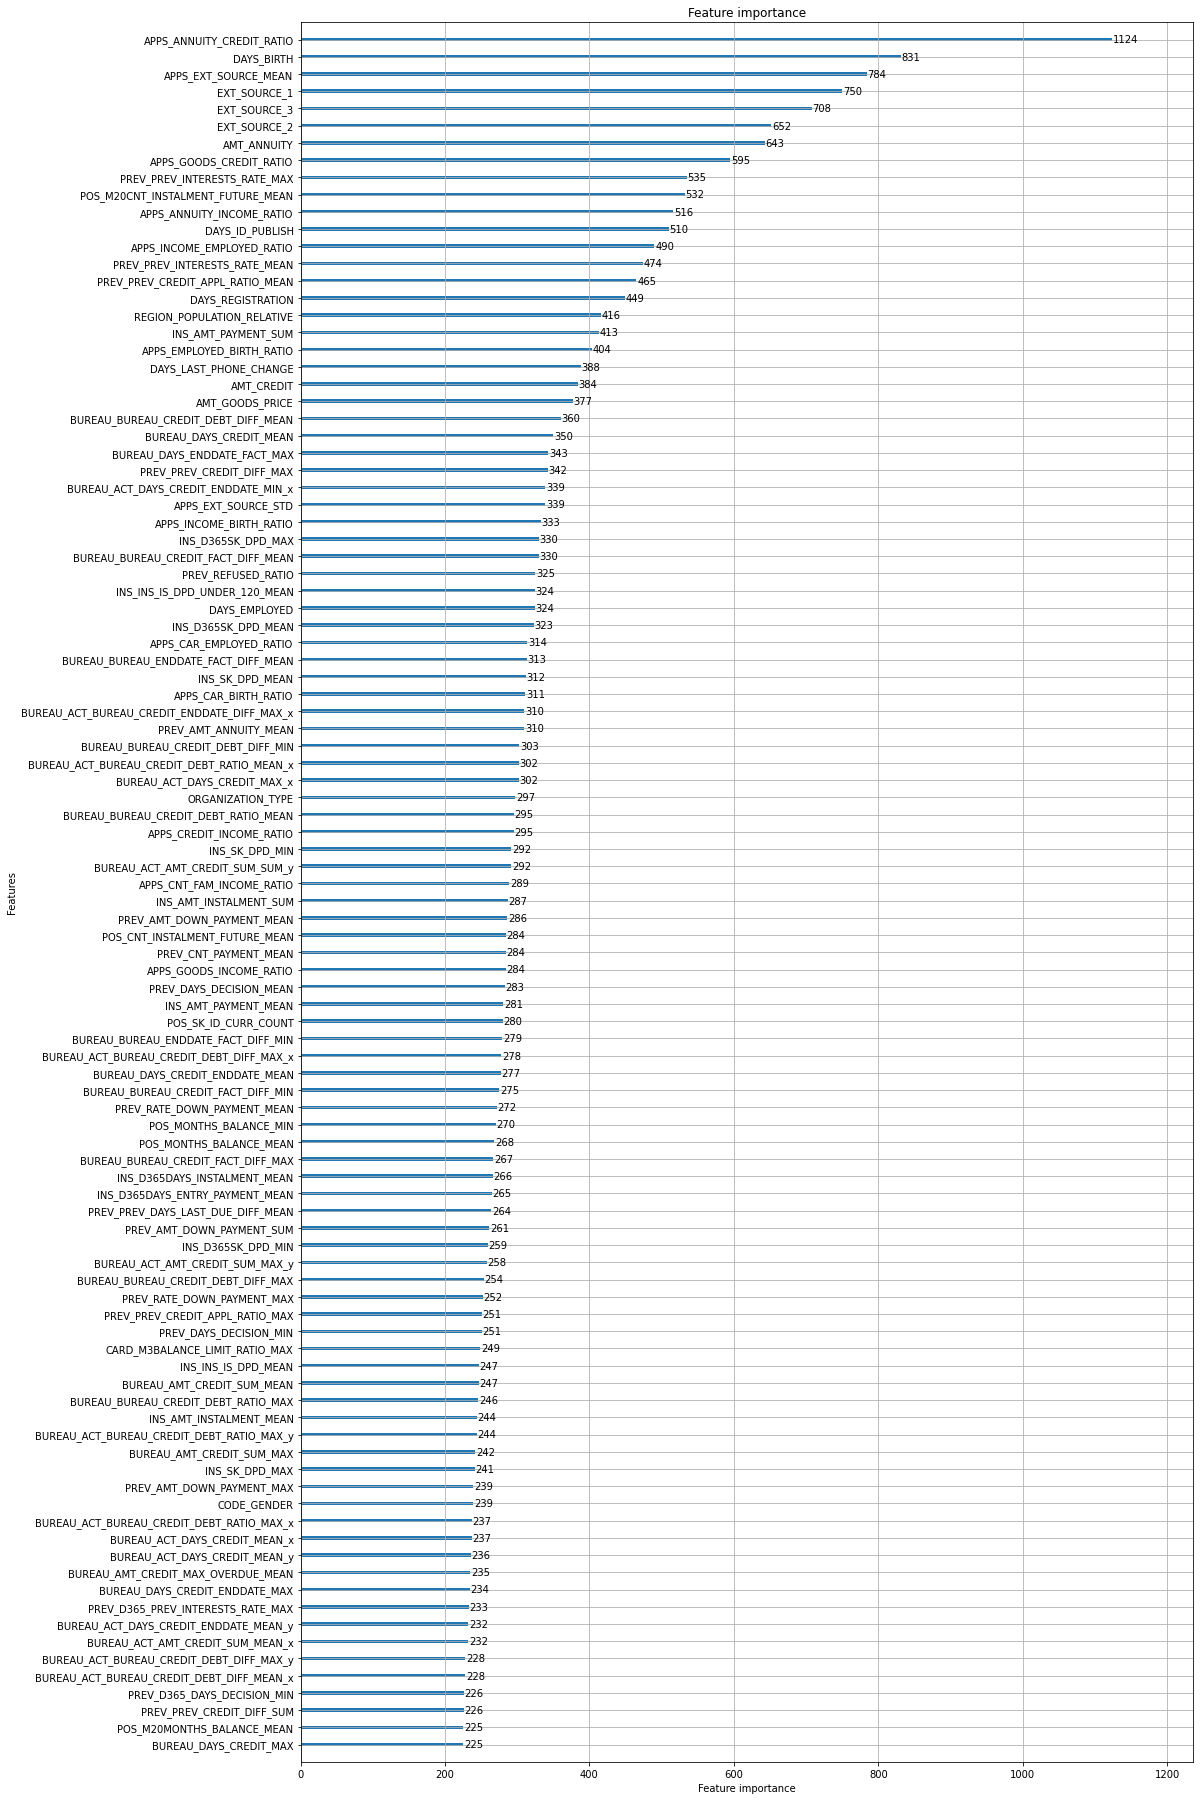

In [21]:
plot_importance(clf, figsize=(16, 32), max_num_features=100)

In [26]:
train_with_pred = pd.read_csv('/content/drive/MyDrive/application_train_with_prediction_added.csv')

from sklearn.metrics import confusion_matrix
y_true = train_with_pred.loc[:,'TARGET']
y_pred = train_with_pred.loc[:,'Predict']
confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fpr = fp / (fp +tn)
fnr = fn / (fn +tp)
print("True Negatives = ",tn)
print("False Positives = ", fp)
print("Fales Negatives =", fn)
print("True Posatives = ", tp)
print("False Positive Rate = ", fpr)
print("False Negative Rate = ", fnr)
print("Accuracy = ", (tp + tn) / (tp + tn + fp + fn))
train_with_pred.head()

True Negatives =  223750
False Positives =  58936
Fales Negatives = 4676
True Posatives =  20149
False Positive Rate =  0.20848574036209788
False Negative Rate =  0.18835850956696878
Accuracy =  0.7931391072189288


,SK_ID_CURR,TARGET,Predict,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,1,Cash loans,M,N,Y,0,202500.0,406597.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,Cash loans,F,N,N,0,270000.0,1293502.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,Cash loans,F,N,Y,0,135000.0,312682.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,Cash loans,M,N,Y,0,121500.0,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#calculate accuracy, fpr, and fnr for subgroups

fpr_list = []
fnr_list = []
accuracy_list = []

temp = train_with_pred.loc[train_with_pred['CODE_GENDER'] == "F"]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['CODE_GENDER'] == "M"]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['REGION_RATING_CLIENT'] == 1]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['REGION_RATING_CLIENT'] == 2]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['REGION_RATING_CLIENT'] == 3]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['CNT_CHILDREN'] == 0]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['CNT_CHILDREN'] == 1]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['CNT_CHILDREN'] == 2]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['CNT_CHILDREN'] == 3]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['CNT_CHILDREN'] == 4]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))


temp = train_with_pred.loc[train_with_pred['FLAG_OWN_CAR'] == "N"]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['FLAG_OWN_CAR'] == "Y"]
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['NAME_EDUCATION_TYPE'] == 'Academic degree']
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['NAME_EDUCATION_TYPE'] == 'Higher education']
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['NAME_EDUCATION_TYPE'] == 'Incomplete higher']
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['NAME_EDUCATION_TYPE'] == 'Lower secondary']
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

temp = train_with_pred.loc[train_with_pred['NAME_EDUCATION_TYPE'] == 'Secondary / secondary special']
tn, fp, fn, tp = confusion_matrix(temp.loc[:,'TARGET'], temp.loc[:,'Predict']).ravel()
fpr_list.append(fp / (fp +tn))
fnr_list.append(fn / (fn +tp))
accuracy_list.append((tp + tn) / (tp + tn + fp + fn))

print(fpr_list)
print(fnr_list)
print(accuracy_list)

[0.17309510404826906, 0.27906656497606036, 0.10181106216348507, 0.20368572344160285, 0.307932222325668, 0.19567120475744862, 0.23630647624180365, 0.23910550458715596, 0.27240250074426914, 0.2807486631016043, 0.22119294466137068, 0.18416468235560915, 0.16149068322981366, 0.12723346600050808, 0.23094098883572567, 0.26654898499558694, 0.23541864663317694]
[0.22448835568101624, 0.14030971374941342, 0.31378865979381443, 0.19779974311721674, 0.12057398434588147, 0.20175808296706604, 0.16464979831316465, 0.15602228889841405, 0.14804469273743018, 0.12727272727272726, 0.1811119485187547, 0.20485744456177402, 0.6666666666666666, 0.2644050885507608, 0.1834862385321101, 0.19424460431654678, 0.17276172915386193]
[0.8233077135857109, 0.73500604422277, 0.8879709289685375, 0.796778627568463, 0.7128698530933167, 0.8038593868255244, 0.7700878613851666, 0.7681408650790684, 0.7395749260156039, 0.7389277389277389, 0.7822140308686996, 0.8143363897998795, 0.8292682926829268, 0.8654208353926506, 0.77308553079

In [28]:
#calculate disparate impact ratios

temp = train_with_pred.loc[train_with_pred['CODE_GENDER'] == "F"]
unpriv_positive_outcome = ( len(temp) - temp['Predict'].sum() ) / len(temp)
temp = train_with_pred.loc[train_with_pred['CODE_GENDER'] == "M"]
priv_positive_outcome = ( len(temp) - temp['Predict'].sum() ) / len(temp)
disp_ratio = unpriv_positive_outcome / priv_positive_outcome
print(disp_ratio)

temp = train_with_pred.loc[train_with_pred['CODE_GENDER'] == "M"]
unpriv_positive_outcome = ( len(temp) - temp['Predict'].sum() ) / len(temp)
temp = train_with_pred.loc[train_with_pred['CODE_GENDER'] == "F"]
priv_positive_outcome = ( len(temp) - temp['Predict'].sum() ) / len(temp)
disp_ratio = unpriv_positive_outcome / priv_positive_outcome
print(disp_ratio)

temp = train_with_pred.loc[train_with_pred['REGION_RATING_CLIENT'] == 3]
unpriv_positive_outcome = ( len(temp) - temp['Predict'].sum() ) / len(temp)
temp = train_with_pred.loc[train_with_pred['REGION_RATING_CLIENT'] == 2]
priv_positive_outcome = ( len(temp) - temp['Predict'].sum() ) / len(temp)
disp_ratio = unpriv_positive_outcome / priv_positive_outcome
print(disp_ratio)

temp = train_with_pred.loc[train_with_pred['REGION_RATING_CLIENT'] == 3]
unpriv_positive_outcome = ( len(temp) - temp['Predict'].sum() ) / len(temp)
temp = train_with_pred.loc[train_with_pred['REGION_RATING_CLIENT'] == 1]
priv_positive_outcome = ( len(temp) - temp['Predict'].sum() ) / len(temp)
disp_ratio = unpriv_positive_outcome / priv_positive_outcome
print(disp_ratio)

1.185323303844419
0.8436516828418452
0.839164874859451
0.7225311237101275


In [29]:
#calculate correlations

temp1 = train_with_pred['REGION_RATING_CLIENT']
temp2 = train_with_pred['REGION_RATING_CLIENT_W_CITY']
print(np.corrcoef(temp1, temp2)[1,0])

temp1 = train_with_pred['REGION_RATING_CLIENT']
temp2 = train_with_pred['AMT_CREDIT']
print(np.corrcoef(temp1, temp2)[1,0])

temp1 = train_with_pred['REGION_RATING_CLIENT']
temp2 = train_with_pred['AMT_INCOME_TOTAL']
print(np.corrcoef(temp1, temp2)[1,0])

temp1 = train_with_pred['AMT_CREDIT']
temp2 = train_with_pred['AMT_INCOME_TOTAL']
print(np.corrcoef(temp1, temp2)[1,0])

temp1 = train_with_pred['REGION_POPULATION_RELATIVE']
temp2 = train_with_pred['AMT_INCOME_TOTAL']
print(np.corrcoef(temp1, temp2)[1,0])

temp1 = train_with_pred['DAYS_BIRTH']
temp2 = train_with_pred['AMT_INCOME_TOTAL']
print(np.corrcoef(temp1, temp2)[1,0])

0.9508422141646397
-0.10177638603517988
-0.08546518870124069
0.15687027185193095
0.07479570273649308
0.027260872582890745


In [32]:
app_train = pd.read_csv('/content/drive/MyDrive/application_train.csv')
#app_test1 = pd.read_csv('/content/drive/MyDrive/application_test.csv')
app_test = pd.read_csv('/content/drive/MyDrive/application_train_with_target_removed.csv')
prev = pd.read_csv('/content/drive/MyDrive/previous_application.csv')
bureau = pd.read_csv('/content/drive/MyDrive/bureau.csv')
bureau_bal = pd.read_csv('/content/drive/MyDrive/bureau_balance.csv')
submission = pd.read_csv('/content/drive/MyDrive/submission.csv')
train_with_pred = pd.read_csv('/content/drive/MyDrive/application_train_with_prediction_added.csv')


#Shortcuts for filenames
df_1 = app_test
df_2 = app_train
df_3 = bureau
df_4 = bureau_bal
df_5 = pos_bal
df_6 = card_bal
df_7 = prev
df_8 = install
df_9 = submission
#df_10 = pd.read_csv("HomeCredit_columns_description.csv", sep=",")
# There is an error associated with HomeCredit_columns_description.csv.  We need to investigate, repair, and note what we've done

list_of_dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9]

#Get the number of rows and columns in each file
print("Shapes of dataframes")
for i in list_of_dfs:
  print(i.shape)
  #print("")


Shapes of dataframes
(307511, 121)
(307511, 122)
(1716428, 17)
(27299925, 3)
(10001358, 11)
(3840312, 28)
(1670214, 37)
(13605401, 14)
(48744, 2)


In [34]:
listOfColumnNames = list(df_1.index)
pd.set_option('display.max_rows', None)
print(df_2.dtypes)


SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


In [35]:
#Check for missing data 

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

for i in list_of_dfs:
  print(missing_data(i))
  print("--------------------------------------------------------")

                               Total    Percent
COMMONAREA_AVG                214865  69.872297
COMMONAREA_MODE               214865  69.872297
COMMONAREA_MEDI               214865  69.872297
NONLIVINGAPARTMENTS_AVG       213514  69.432963
NONLIVINGAPARTMENTS_MODE      213514  69.432963
NONLIVINGAPARTMENTS_MEDI      213514  69.432963
FONDKAPREMONT_MODE            210295  68.386172
LIVINGAPARTMENTS_MEDI         210199  68.354953
LIVINGAPARTMENTS_AVG          210199  68.354953
LIVINGAPARTMENTS_MODE         210199  68.354953
FLOORSMIN_AVG                 208642  67.848630
FLOORSMIN_MODE                208642  67.848630
FLOORSMIN_MEDI                208642  67.848630
YEARS_BUILD_AVG               204488  66.497784
YEARS_BUILD_MEDI              204488  66.497784
YEARS_BUILD_MODE              204488  66.497784
OWN_CAR_AGE                   202929  65.990810
LANDAREA_MEDI                 182590  59.376738
LANDAREA_AVG                  182590  59.376738
LANDAREA_MODE                 182590  59

median: AMT_INCOME_TOTAL 147150.0
mean: AMT_INCOME_TOTAL 168797.9192969845
min: AMT_INCOME_TOTAL 25650.0
max: AMT_INCOME_TOTAL 117000000.0


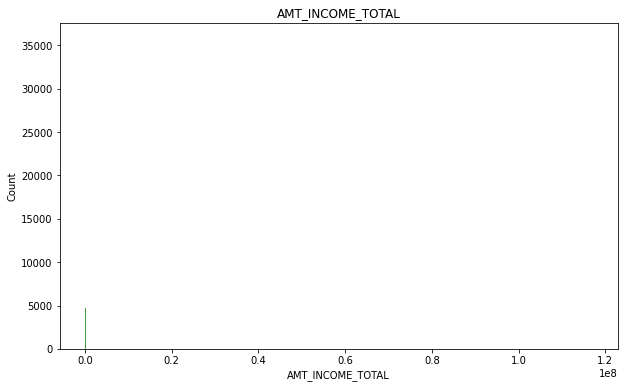

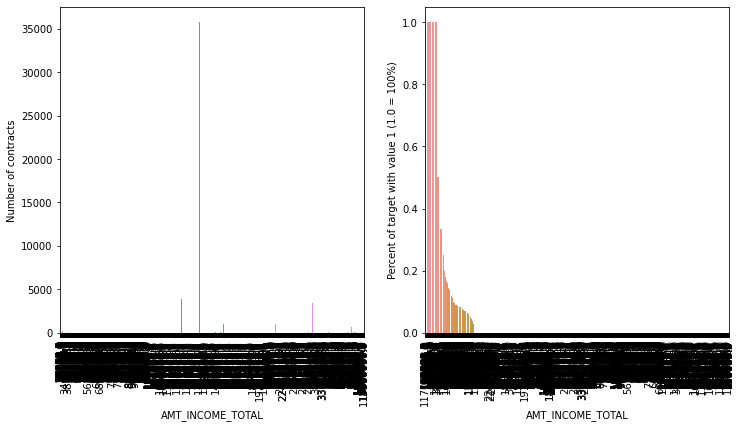

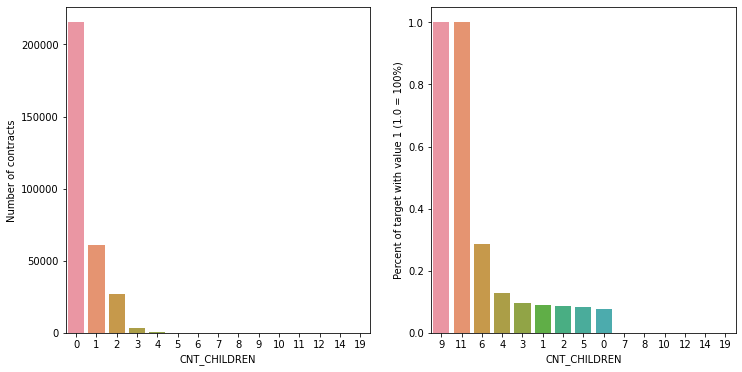

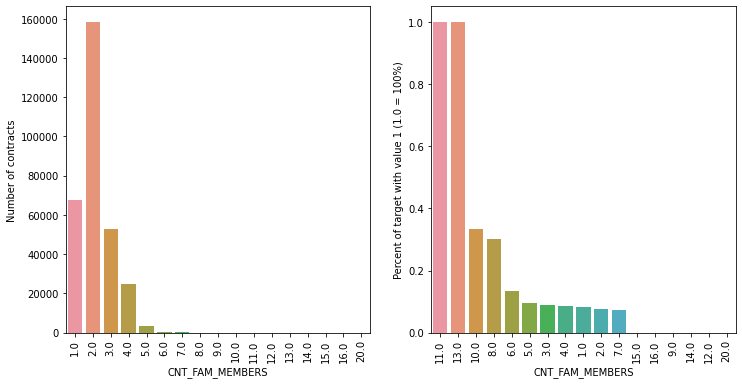

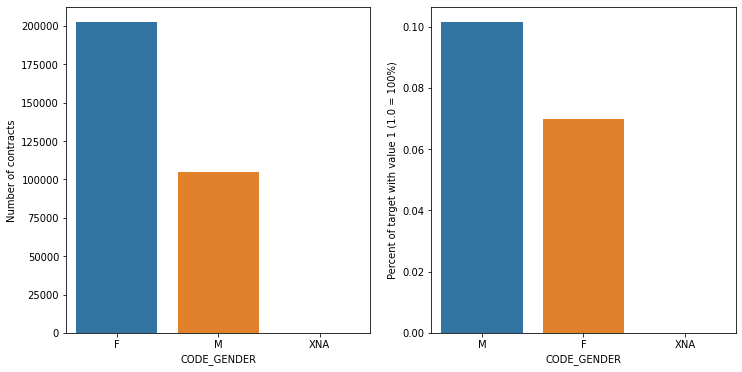

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


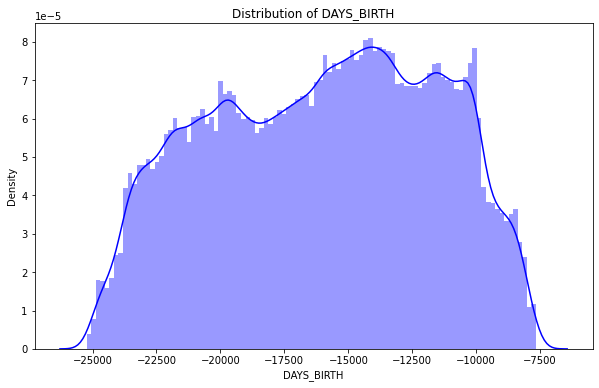

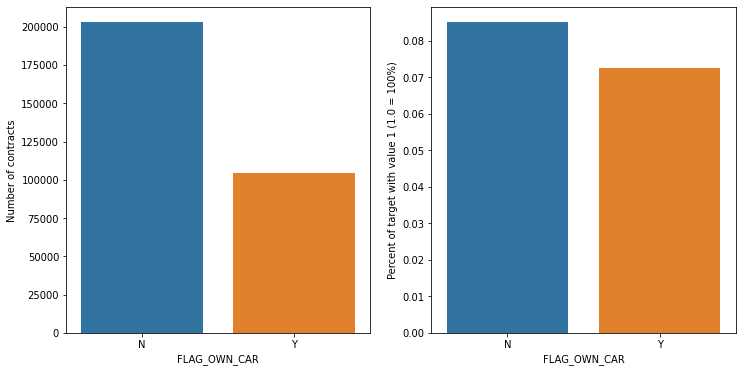

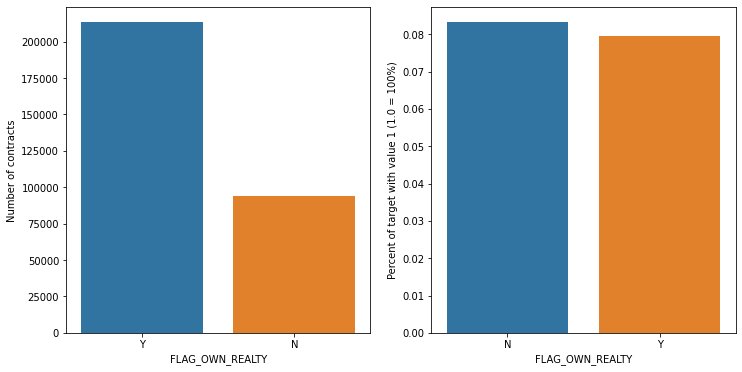

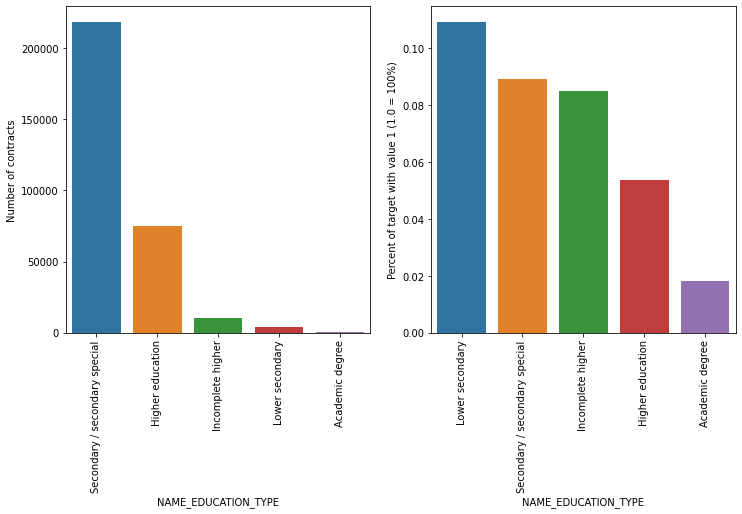

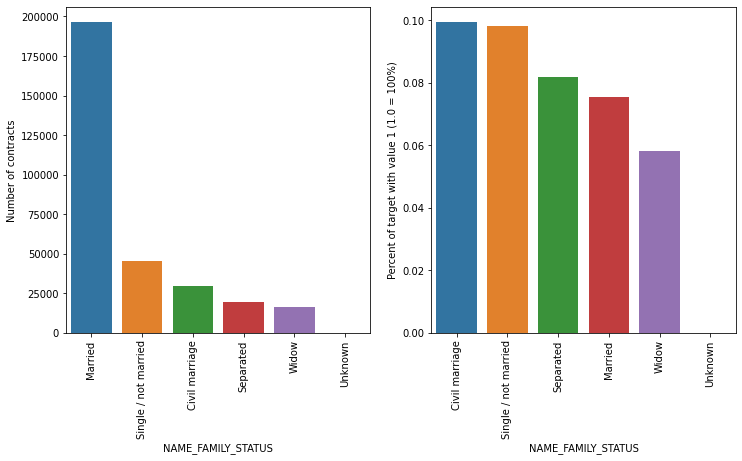

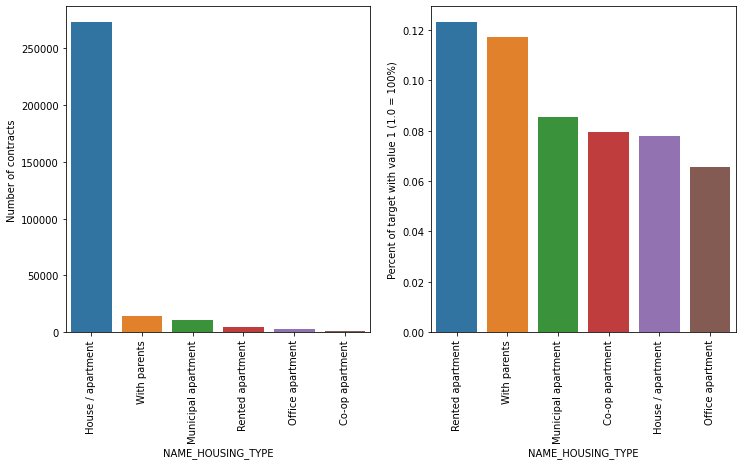

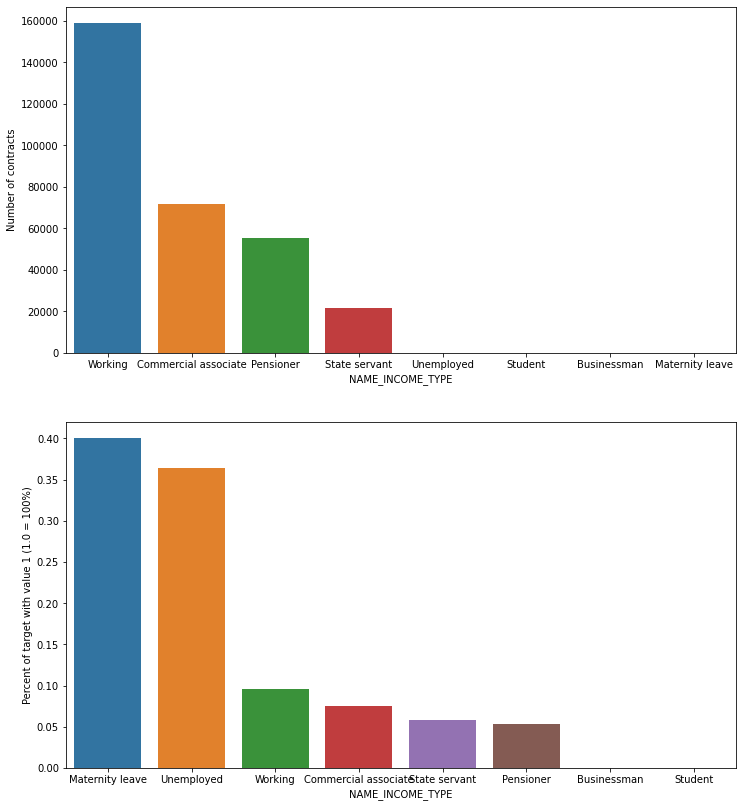

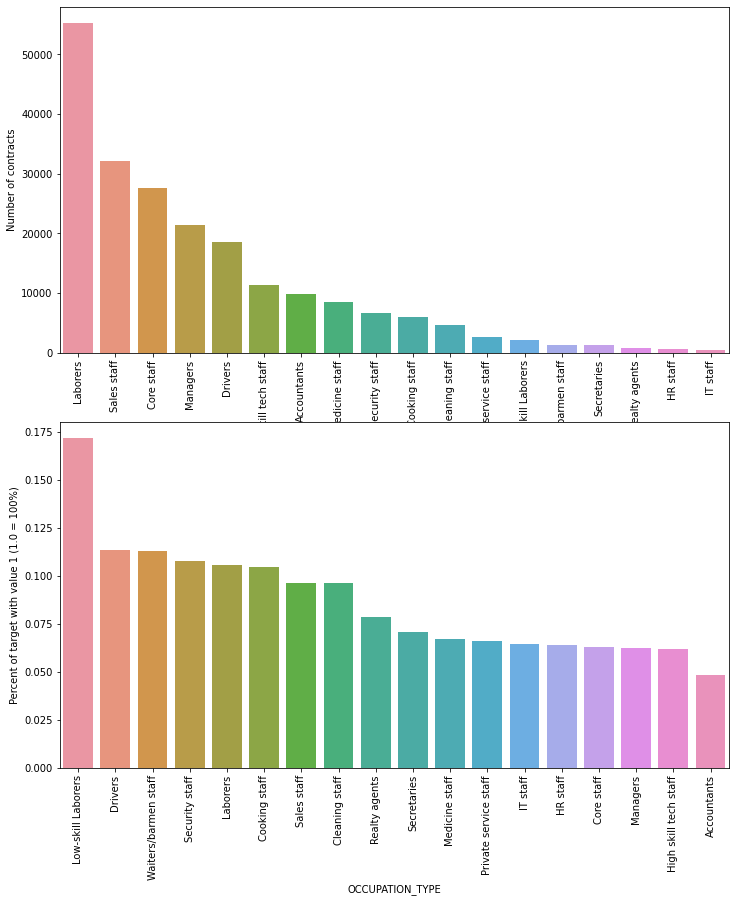

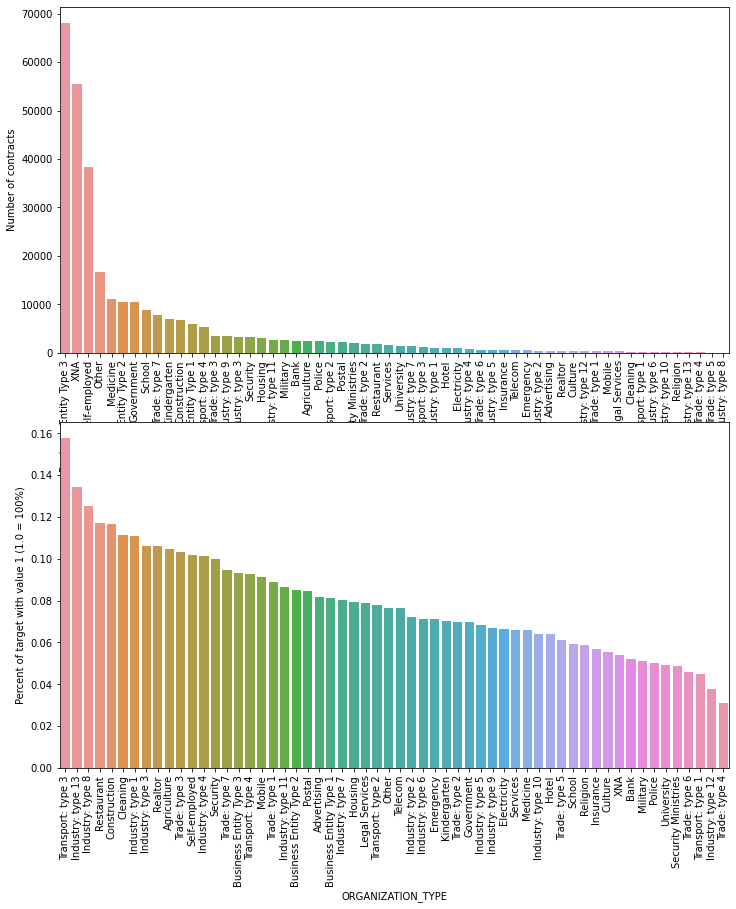

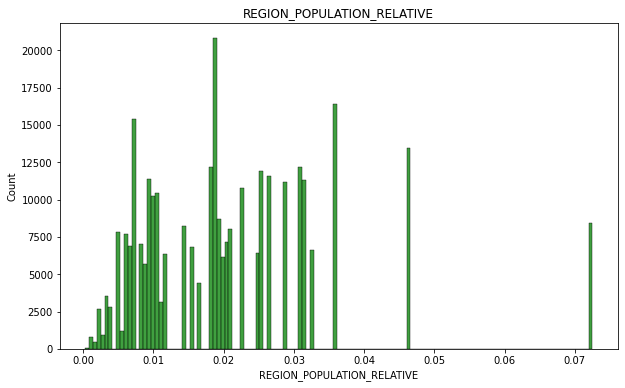

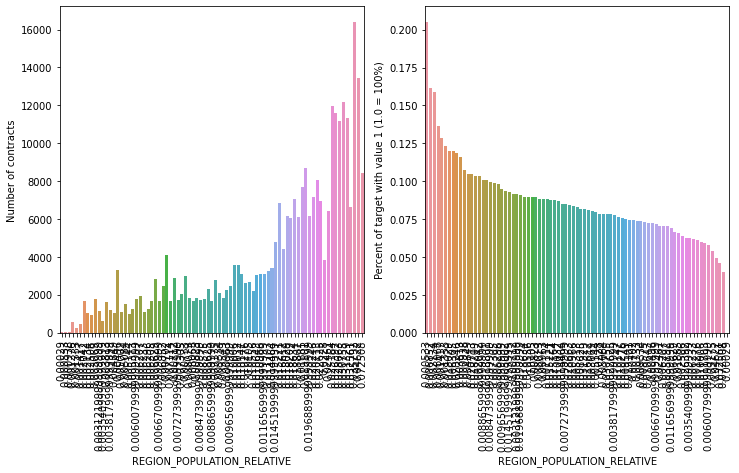

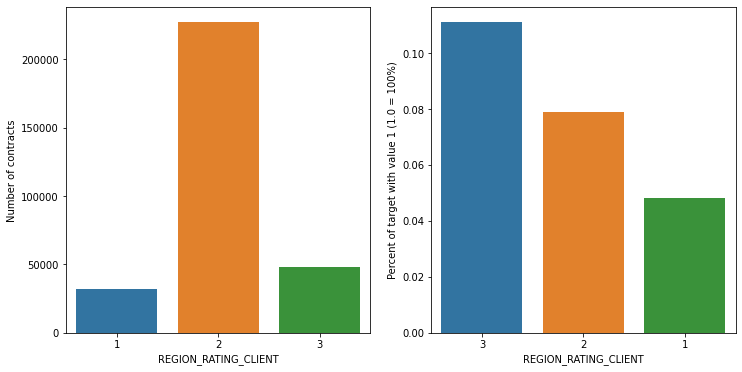

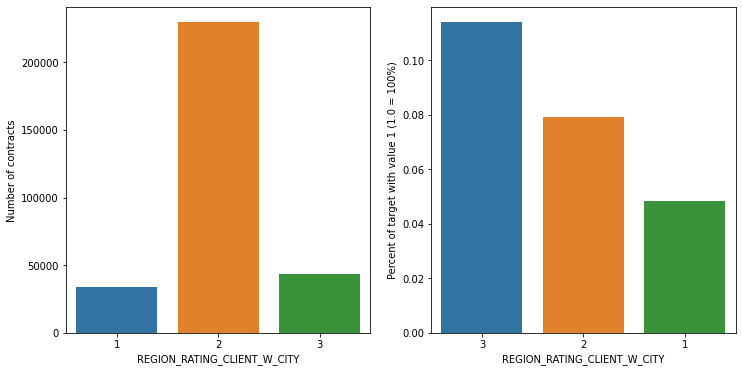

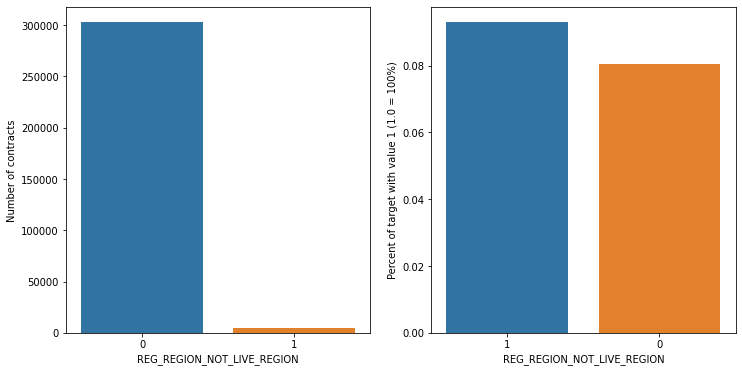

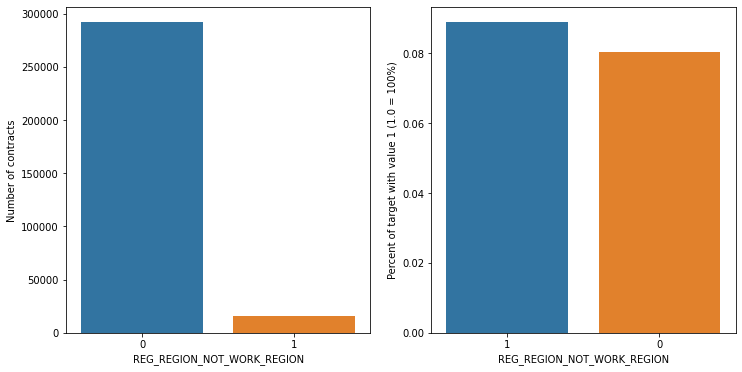

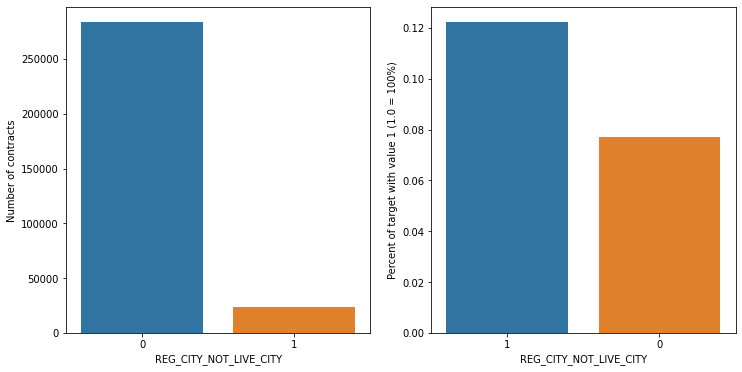

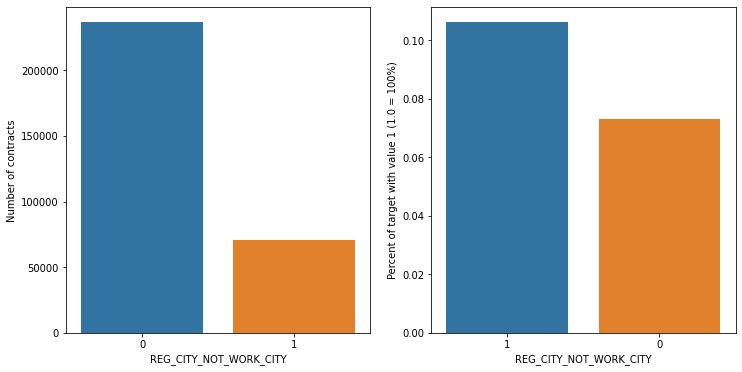

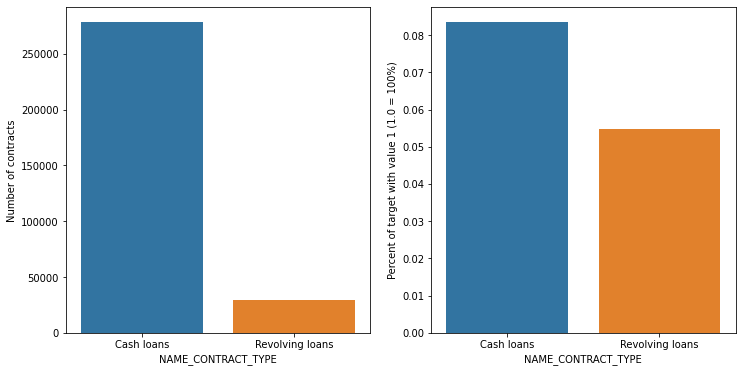

In [36]:
#Plots of various features

def plot_stats(feature,label_rotation=False,horizontal_layout=True):
  temp = df_2[feature].value_counts()
  df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

  # Calculate the percentage of target=1 per category value
  cat_perc = df_2[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
  cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
  
  if(horizontal_layout):
      fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
  else:
      fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
  sns.set_color_codes("pastel")
  s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
  if(label_rotation):
      s.set_xticklabels(s.get_xticklabels(),rotation=90)
  
  s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
  if(label_rotation):
      s.set_xticklabels(s.get_xticklabels(),rotation=90)
  plt.ylabel('Percent of target with value 1 (1.0 = 100%)', fontsize=10)
  plt.tick_params(axis='both', which='major', labelsize=10)
  plt.show();

def plot_distribution(var):
    i = 0
    t1 = df_2.loc[df_2['TARGET'] != 0]
    t0 = df_2.loc[df_2['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

# Plot histogram of one feature
def plot_histogram(feature,color):
    plt.figure(figsize=(10,6))
    plt.title(feature)
    sns.histplot(df_2[feature].dropna(),color=color)
    plt.show() 

# Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(df_2[feature].dropna(),color=color, kde=True, bins=100)
    plt.show() 

print("median: AMT_INCOME_TOTAL", df_2["AMT_INCOME_TOTAL"].median())
print("mean: AMT_INCOME_TOTAL", df_2["AMT_INCOME_TOTAL"].mean())
print("min: AMT_INCOME_TOTAL", df_2["AMT_INCOME_TOTAL"].min())
print("max: AMT_INCOME_TOTAL", df_2["AMT_INCOME_TOTAL"].max())
plot_histogram('AMT_INCOME_TOTAL','green')
plot_stats('AMT_INCOME_TOTAL','green')
plot_stats('CNT_CHILDREN')
plot_stats('CNT_FAM_MEMBERS',True)
plot_stats('CODE_GENDER')
plot_distribution('DAYS_BIRTH','blue')
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')
plot_stats('NAME_EDUCATION_TYPE',True)
plot_stats('NAME_FAMILY_STATUS',True, True)
plot_stats('NAME_HOUSING_TYPE',True)
plot_stats('NAME_INCOME_TYPE',False,False)
plot_stats('OCCUPATION_TYPE',True, False)
plot_stats('ORGANIZATION_TYPE',True, False)
plot_histogram('REGION_POPULATION_RELATIVE','green')
plot_stats('REGION_POPULATION_RELATIVE','green')
plot_stats('REGION_RATING_CLIENT')
plot_stats('REGION_RATING_CLIENT_W_CITY')

plot_stats('REG_REGION_NOT_LIVE_REGION')
plot_stats('REG_REGION_NOT_WORK_REGION')
plot_stats('REG_CITY_NOT_LIVE_CITY')
plot_stats('REG_CITY_NOT_WORK_CITY')
plot_stats("NAME_CONTRACT_TYPE")

In [37]:
#Examine the data

#Get the number of rows and columns in each file
print("Shapes of dataframes")
for i in list_of_dfs:
  print(i.shape)
  #print("")

# show the boolean dataframe            
print(" \nshow the boolean Dataframe : \n\n", df_2.isnull())
print("")

# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      df_1.isnull().sum())
print("")

#Create a dictionary
dataTypeDict1 = {}
dataTypeDict2 = {}
for i in list_of_dfs:
  dataTypeDict2 = dict(i.dtypes)
  dataTypeDict1.update(dataTypeDict2)
print("The number of items in the data dictinary is: ", len(dataTypeDict1))

#Copy datafraes to an adjusted version where we can add cloumns. This way we maintain the integrity of the original files.
df_1_adj = df_1
df_2_adj = df_2
df_3_adj = df_3
df_4_adj = df_4
df_5_adj = df_5
df_6_adj = df_6
df_7_adj = df_7
df_8_adj = df_8
df_9_adj = df_9

#Convert age from days into years and add a column to the respective databases
df_1_adj["M_age_in_years"] = (df_1_adj["DAYS_BIRTH"] / -365.25)
df_2_adj["M_age_in_years"] = (df_2_adj["DAYS_BIRTH"] / -365.25)

#Add a new column that expresses education in a shorrt label
df_1_adj["M_education"] = (df_1_adj["NAME_EDUCATION_TYPE"])
df_2_adj["M_education"] = (df_2_adj["NAME_EDUCATION_TYPE"])
df_1_adj["M_education"].replace(["Academic degree"],"A")
df_1_adj["M_education"].replace(['Higher education'],'B')
df_1_adj["M_education"].replace(["Incomplete higher"],'C')
df_1_adj["M_education"].replace('Lower secondary','D')
df_1_adj["M_education"].replace('Secondary / secondary special','E')
#df_2.replace('Academic degree','1', regex=True)
#df_2 = df_2.replace('Higher education','2', regex=True)
#df_2 = df_2.replace('Incomplete higher','3', regex=True)
#df_2 = df_2_adj.replace('Lower secondary','4', regex=True)
#df_2 = df_2.replace('Seconday / secondary special','5', regex=True)
print("Value Counts")
occur = df_1_adj.groupby(['M_education']).size()
print(occur)

#list of values of 'Marks' column
marks_list = df_1_adj['M_education'].tolist()
  
# show the list
print(marks_list)

Shapes of dataframes
(307511, 121)
(307511, 122)
(1716428, 17)
(27299925, 3)
(10001358, 11)
(3840312, 28)
(1670214, 37)
(13605401, 14)
(48744, 2)
 
show the boolean Dataframe : 

 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 
Count total NaN at each column in a DataFrame : 

 SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_M

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


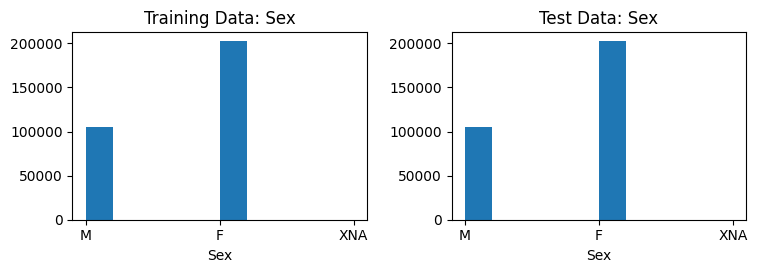

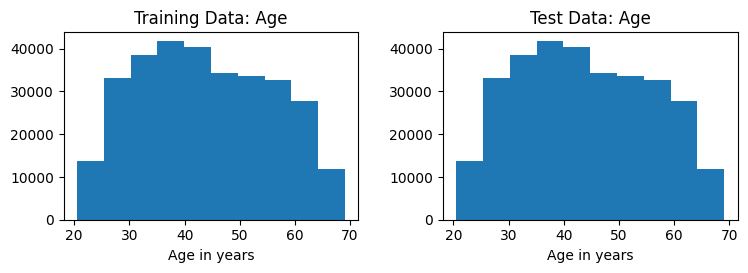

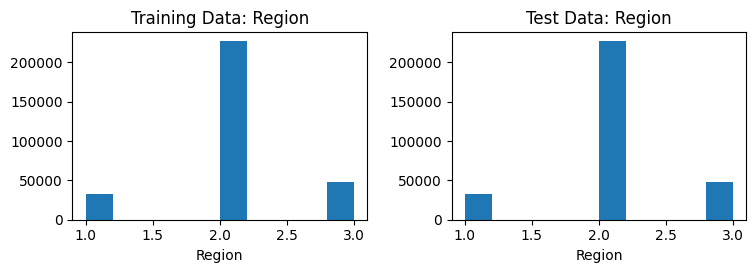

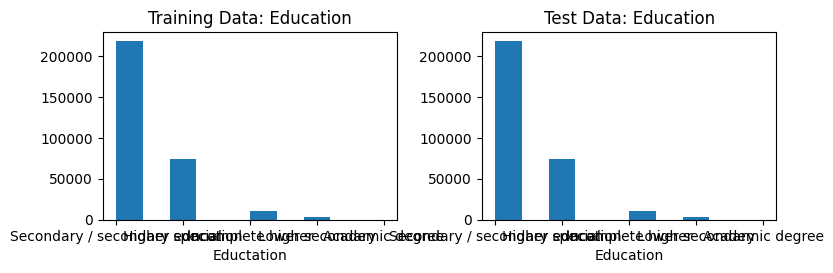

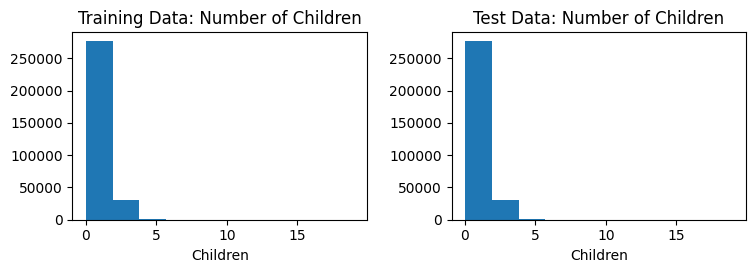

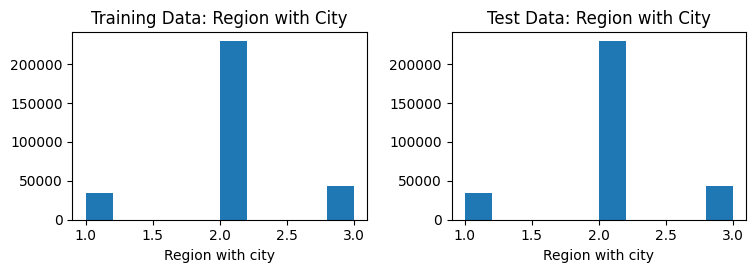

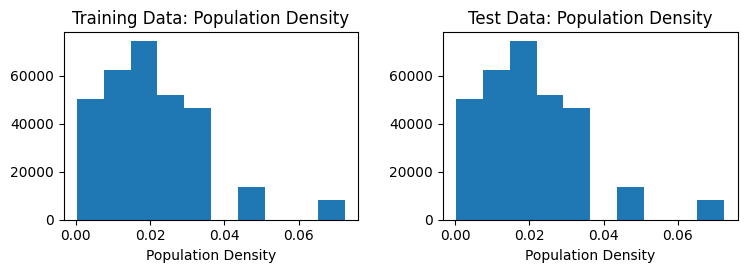

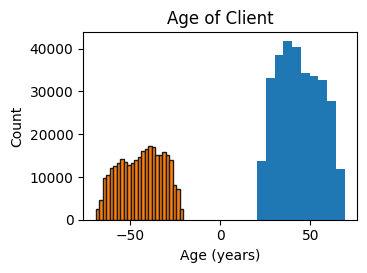

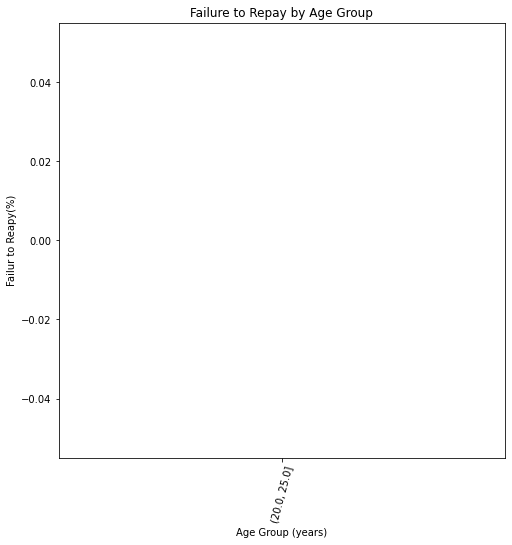

In [38]:
# Box plots of attributes that we are curious about

#Gender
fig1, axes1 = plt.subplots(1, 2, figsize=(8,3), dpi=100)
fig1.tight_layout(pad=3.0)
axes1[0].hist(df_2['CODE_GENDER'])
axes1[1].hist(df_1['CODE_GENDER'])
axes1[0].set_xlabel('Sex')
axes1[1].set_xlabel('Sex')
axes1[0].set_title('Training Data: Sex')
axes1[1].set_title('Test Data: Sex')

#Age
fig2, axes2 = plt.subplots(1, 2, figsize=(8,3), dpi=100)
fig2.tight_layout(pad=3.0)
axes2[0].hist(df_2_adj['M_age_in_years'])
axes2[1].hist(df_1_adj['M_age_in_years'])
axes2[0].set_xlabel('Age in years')
axes2[1].set_xlabel('Age in years')
axes2[0].set_title('Training Data: Age')
axes2[1].set_title('Test Data: Age')

#REGION_RATING_CLIENT
fig3, axes3 = plt.subplots(1, 2, figsize=(8,3), dpi=100)
fig3.tight_layout(pad=3.0)
axes3[0].hist(df_2['REGION_RATING_CLIENT'])
axes3[1].hist(df_1['REGION_RATING_CLIENT'])
axes3[0].set_xlabel('Region')
axes3[1].set_xlabel('Region')
axes3[0].set_title('Training Data: Region')
axes3[1].set_title('Test Data: Region')

#NAME_EDUCATION_TYPE -*** Replace the names with shorter names that can be read on the plot
fig4, axes4 = plt.subplots(1, 2, figsize=(8,3), dpi=100)
fig4.tight_layout(pad=3.0)
axes4[0].hist(df_2_adj['M_education'])
axes4[1].hist(df_1_adj['M_education'])
axes4[0].set_xlabel('Eductation')
axes4[1].set_xlabel('Education')
axes4[0].set_title('Training Data: Education')
axes4[1].set_title('Test Data: Education')

#CNT_CHILDREN - ***There are illogical results here.  Someone has 20 children
fig5, axes5 = plt.subplots(1, 2, figsize=(8,3), dpi=100)
fig5.tight_layout(pad=3.0)
axes5[0].hist(df_2['CNT_CHILDREN'])
axes5[1].hist(df_1['CNT_CHILDREN'])
axes5[0].set_xlabel('Children')
axes5[1].set_xlabel('Children')
axes5[0].set_title('Training Data: Number of Children')
axes5[1].set_title('Test Data: Number of Children')

#REGION_RATING_CLIENT_W_CITY
fig6, axes6 = plt.subplots(1, 2, figsize=(8,3), dpi=100)
fig6.tight_layout(pad=3.0)
axes6[0].hist(df_2['REGION_RATING_CLIENT_W_CITY'])
axes6[1].hist(df_1['REGION_RATING_CLIENT_W_CITY'])
axes6[0].set_xlabel('Region with city')
axes6[1].set_xlabel('Region with city')
axes6[0].set_title('Training Data: Region with City')
axes6[1].set_title('Test Data: Region with City')

#REGION_POPULATION_RELATIVE
fig7, axes7 = plt.subplots(1, 2, figsize=(8,3), dpi=100)
fig7.tight_layout(pad=3.0)
axes7[0].hist(df_2['REGION_POPULATION_RELATIVE'])
axes7[1].hist(df_1['REGION_POPULATION_RELATIVE'])
axes7[0].set_xlabel('Population Density')
axes7[1].set_xlabel('Population Density')
axes7[0].set_title('Training Data: Population Density')
axes7[1].set_title('Test Data: Population Density')

#Age
fig8, axes8 = plt.subplots(1, 1, figsize=(4,3), dpi=100)
fig8.tight_layout(pad=3.0)
axes8.hist(df_2_adj['M_age_in_years'])
axes8.set_xlabel('Age in years')
axes8.set_title('Training Data: Age')


#-------------------------------------------------
#plt.style.use('fivethirtyeight')
plt.hist(df_2['DAYS_BIRTH']/365.25, edgecolor='k',bins=25)
plt.title('Age of Client');
plt.xlabel('Age (years)');
plt.ylabel('Count');


#------------------------------------------
np.linspace(20,70,num=11)
#------------------------------------------
age_data=df_2[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH']=age_data['DAYS_BIRTH']/365

# Bin the age data
age_data['YEARS_BINNED']=pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head(10)
#----------------------------------------
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups
#----------------------------------------
plt.figure(figsize=(8,8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75);
plt.xlabel('Age Group (years)');
plt.ylabel('Failur to Reapy(%)')
plt.title('Failure to Repay by Age Group');

In [40]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      df_1.isnull().sum())

correlations = df_2.corr()['TARGET'].sort_values()

print('Most Positive Correlations: \n', correlations.tail(15))
print('\nMost Negative Correlations: \n', correlations.head(15))

 
Count total NaN at each column in a DataFrame : 

 SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_M